<a href="https://colab.research.google.com/github/mangaorphy/UNSW-Predators/blob/main/UNSW_Predators_CNNDEEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦘 UNSW Predators - Australian Wildlife Classification

**Deep Learning approach for classifying Australian wildlife using CNN and Transfer Learning**

## Project Overview
This notebook implements a comprehensive deep learning pipeline to classify five species of Australian wildlife from camera trap images.

### Dataset
- **Species**: Dingo, Fox, Goanna, Possum, Quoll
- **Source**: UNSW Predators Dataset
- **Location**: `unsw_images_organized/`

### Approach
1. **Data Preprocessing**: Optimized tf.data pipeline with augmentation
2. **Model Training**: 6 different CNN architectures (Custom + Transfer Learning)
3. **Evaluation**: Comprehensive metrics including accuracy, AUC, confusion matrices
4. **Model Selection**: Automated best model selection and saving

### Models
- **Custom CNN** (2 configurations)
- **EfficientNetB0** with Transfer Learning (2 configurations)
- **ResNet50** with Transfer Learning (2 configurations)

## 1. Setup and Imports

In [ ]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


# Image processing
from PIL import Image
import cv2

# Sklearn for classical ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, accuracy_score, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# For feature extraction (classical ML)
from tensorflow.keras.applications import VGG16

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Data Loading and Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy all files from google drive(~22GB)
!cp -r "/content/drive/MyDrive/UNSW_Predators" .

In [ ]:
# Set paths
DATA_DIR = Path("/content/UNSW_Predators")
CLASSES = ['dingo', 'fox', 'goanna', 'possum', 'quoll']

# Collect all image paths and labels
image_paths = []
labels = []

for class_name in CLASSES:
    class_dir = DATA_DIR / class_name
    for img_path in class_dir.glob('*.JPG'):
        image_paths.append(str(img_path))
        labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(f"Total images: {len(df)}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass distribution (%):")
print(df['label'].value_counts(normalize=True) * 100)

Total images: 17175

Class distribution:
label
dingo     5458
goanna    4392
quoll     4078
fox       2210
possum    1037
Name: count, dtype: int64

Class distribution (%):
label
dingo     31.778748
goanna    25.572052
quoll     23.743814
fox       12.867540
possum     6.037846
Name: proportion, dtype: float64


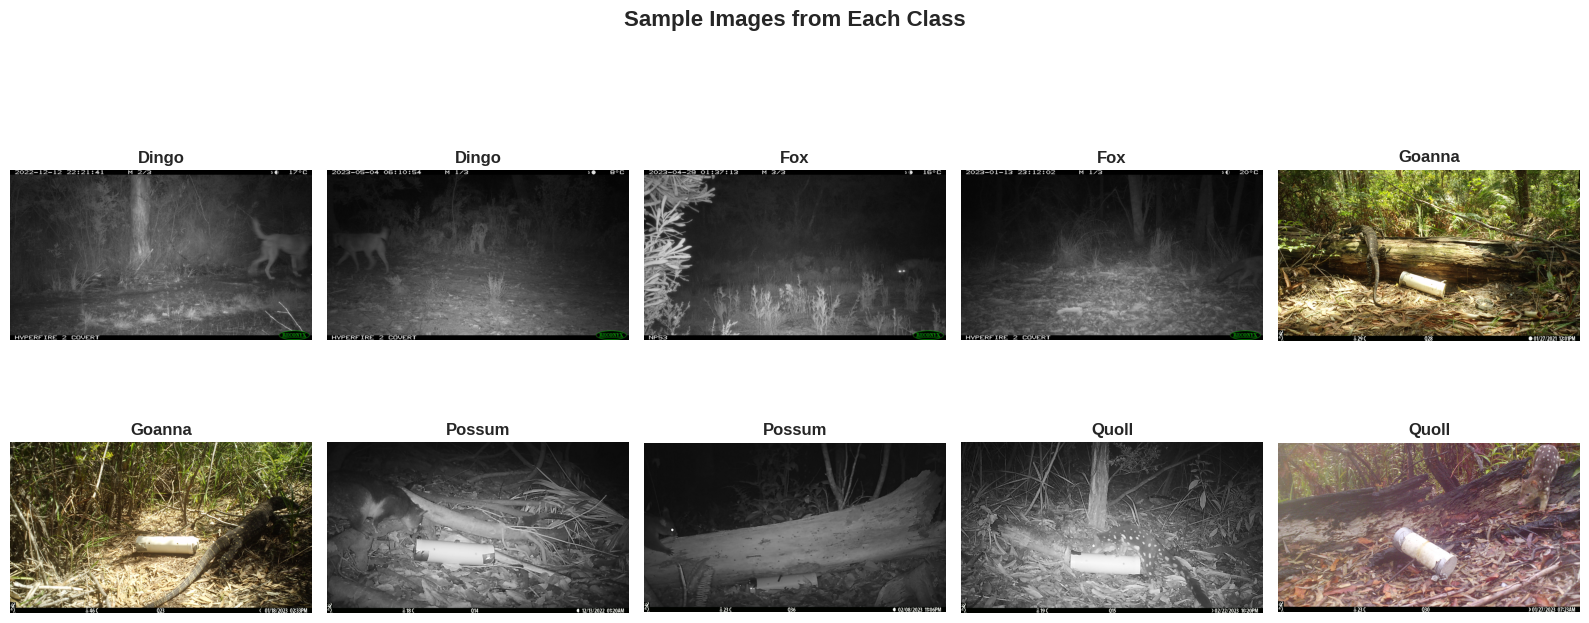

In [ ]:
# Display sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.ravel()

for idx, class_name in enumerate(CLASSES):
    # Get 2 random samples per class
    class_samples = df[df['label'] == class_name].sample(2, random_state=42)

    for i, (_, row) in enumerate(class_samples.iterrows()):
        img = Image.open(row['image_path'])
        axes[idx * 2 + i].imshow(img)
        axes[idx * 2 + i].set_title(f"{class_name.capitalize()}", fontweight='bold')
        axes[idx * 2 + i].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Data Preparation and Splitting

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Split data: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"\nTrain set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

print("\nTrain set distribution:")
print(train_df['label'].value_counts())
print("\nValidation set distribution:")
print(val_df['label'].value_counts())
print("\nTest set distribution:")
print(test_df['label'].value_counts())

Label Mapping: {'dingo': np.int64(0), 'fox': np.int64(1), 'goanna': np.int64(2), 'possum': np.int64(3), 'quoll': np.int64(4)}

Train set: 12022 images
Validation set: 2576 images
Test set: 2577 images

Train set distribution:
label
dingo     3820
goanna    3074
quoll     2855
fox       1547
possum     726
Name: count, dtype: int64

Validation set distribution:
label
dingo     819
goanna    659
quoll     611
fox       331
possum    156
Name: count, dtype: int64

Test set distribution:
label
dingo     819
goanna    659
quoll     612
fox       332
possum    155
Name: count, dtype: int64


In [ ]:
# ==========================
# 3️⃣ Weighted Loss
# ==========================
# Compute class weights for imbalanced dataset
class_counts = train_df['label_encoded'].value_counts().sort_index().values
total_samples = len(train_df)
class_weights = {i: total_samples / (len(CLASSES) * count) for i, count in enumerate(class_counts)}
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6294240837696335), 1: np.float64(1.5542340012928249), 2: np.float64(0.7821730644111906), 3: np.float64(3.311845730027548), 4: np.float64(0.8421716287215412)}


## 4. Deep Learning Models

This section implements and trains CNN models with comprehensive evaluation after each model.

### Models Overview:
1. **Custom CNN** (2 configurations) - Built from scratch
2. **EfficientNetB0** (2 configurations) - Transfer Learning
3. **ResNet50** (2 configurations) - Transfer Learning

Each model will be:
- Trained with optimized data pipeline
- Evaluated on test set immediately after training
- Visualized with 7 comprehensive plots (loss, accuracy, AUC, confusion matrix, ROC curves, predictions, per-class metrics)

### 4.1 Data Pipeline Setup

**Performance Optimizations Applied:**

The data pipeline uses `tf.data` API with several key optimizations:

1. **Prefetching (`AUTOTUNE`)**: While the model trains on the current batch, the data pipeline prepares the next batch in parallel, reducing GPU idle time.

2. **Parallel Data Loading**: Multiple images are loaded and preprocessed simultaneously using `num_parallel_calls=AUTOTUNE`.

3. **Caching**: After the first epoch, decoded images are cached in memory, eliminating repeated disk I/O operations.

4. **Large Shuffle Buffer**: A buffer of 1000 samples ensures proper randomization during training.

5. **Efficient Augmentation**: Using Keras layers for augmentation is faster than ImageDataGenerator.

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# ==========================
#Data Parameters - OPTIMIZED FOR SPEED
# ==========================
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

# Enable GPU memory growth to prevent OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

# Enable XLA (Accelerated Linear Algebra) for faster computation
tf.config.optimizer.set_jit(True)
print("✓ XLA JIT compilation enabled")

# Data augmentation - Simplified for speed
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
], name='data_augmentation')

# ==========================
#Data Pipeline Functions
# ==========================
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # instead of dividing by 255
    return image, label

def augment_image(image, label):
    image = data_augmentation(image, training=True)
    return image, label

# ==========================
#Prepare Datasets
# ==========================
def prepare_dataset(df, augment=False, use_memory_cache=False):
    """Highly optimized data pipeline for maximum training speed"""
    files = df['image_path'].values
    labels = to_categorical(df['label_encoded'].values, num_classes=len(CLASSES))

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))

    # Options for better performance
    options = tf.data.Options()
    options.experimental_optimization.map_parallelization = True
    options.experimental_optimization.parallel_batch = True
    options.threading.private_threadpool_size = 48
    options.threading.max_intra_op_parallelism = 1
    dataset = dataset.with_options(options)

    if augment:
        dataset = dataset.shuffle(buffer_size=500, seed=42, reshuffle_each_iteration=True)
        # Parse and augment in one step
        dataset = dataset.map(lambda f, l: augment_image(*parse_image(f, l), l),
                             num_parallel_calls=AUTOTUNE)
        # Batch with prefetch
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    else:
        # Parse images
        dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
        # Cache validation/test sets in memory
        if use_memory_cache:
            dataset = dataset.cache()
        # Batch with prefetch
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

def augment_image(image, label, label_copy):
    """Combined augmentation function"""
    image = data_augmentation(image, training=True)
    return image, label_copy

# ==========================
# Create Datasets - FAST Pipeline
# ==========================
print("Creating optimized datasets...")
train_dataset = prepare_dataset(train_df, augment=True, use_memory_cache=False)
val_dataset = prepare_dataset(val_df, augment=False, use_memory_cache=True)
test_dataset = prepare_dataset(test_df, augment=False, use_memory_cache=True)

# ==========================
# Steps per Epoch
# ==========================
# Setting to None allows TensorFlow to use all available batches
steps_per_epoch = None
validation_steps = None
test_steps = None

print(f"✓ Datasets ready!")
print(f"Train samples: {len(train_df)} (Batch size: {BATCH_SIZE})")
print(f"Val samples: {len(val_df)} (Batch size: {BATCH_SIZE})")
print(f"Test samples: {len(test_df)} (Batch size: {BATCH_SIZE})")
print(f"Class weights: {class_weights}")

✓ GPU memory growth enabled for 1 GPU(s)
✓ XLA JIT compilation enabled
Creating optimized datasets...
✓ Datasets ready!
Train samples: 12022 (Batch size: 128)
Val samples: 2576 (Batch size: 128)
Test samples: 2577 (Batch size: 128)
Class weights: {0: np.float64(0.6294240837696335), 1: np.float64(1.5542340012928249), 2: np.float64(0.7821730644111906), 3: np.float64(3.311845730027548), 4: np.float64(0.8421716287215412)}


### 4.2 Model Architectures - Custom CNN

In [ ]:
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=5, dropout_rate=0.5, filters_base=32):
    """Create a custom CNN model"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(filters_base, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(filters_base, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.5),

        # Block 2
        layers.Conv2D(filters_base * 2, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters_base * 2, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.5),

        # Block 3
        layers.Conv2D(filters_base * 4, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters_base * 4, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.75),

        # Block 4
        layers.Conv2D(filters_base * 8, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate * 0.75),

        # Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create two custom CNN configurations
print("Custom CNN Architecture:")
custom_cnn_config1 = create_custom_cnn(dropout_rate=0.5, filters_base=32)
custom_cnn_config1.summary()

Custom CNN Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,465,381 (51.37 MB)

 Trainable params: 13,463,205 (51.36 MB)

 Non-trainable params: 2,176 (8.50 KB)

### 4.3 Model Architectures - Transfer Learning (EfficientNetB0 & ResNet50)

### 4.4 Training Configuration & Callbacks

In [ ]:
def create_transfer_model(base_model_name='EfficientNetB0', input_shape=(224, 224, 3),
                          num_classes=5, trainable_layers=20, dropout_rate=0.3):
    """Create a transfer learning model"""

    # Load base model
    if base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported model")

    # Freeze early layers, train later layers
    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

print("Transfer Learning Model Architectures:\n")
print("="*80)
print("\n1. EfficientNetB0 Configuration 1:")
effnet_config1 = create_transfer_model('EfficientNetB0', trainable_layers=20, dropout_rate=0.3)
print(f"Total params: {effnet_config1.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in effnet_config1.trainable_weights]):,}")

print("\n2. ResNet50 Configuration 1:")
resnet_config1 = create_transfer_model('ResNet50', trainable_layers=15, dropout_rate=0.3)
print(f"Total params: {resnet_config1.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in resnet_config1.trainable_weights]):,}")

Transfer Learning Model Architectures:


1. EfficientNetB0 Configuration 1:
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Total params: 4,219,816
Trainable params: 1,518,389

2. ResNet50 Configuration 1:
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Total params: 23,859,333
Trainable params: 5,787,653


In [ ]:
# ==========================
# Mixed Precision Training (ENABLED for speed on GPUs)
# ==========================
from tensorflow.keras import mixed_precision

try:
    mixed_precision.set_global_policy('mixed_float16')
    print("✓ Mixed precision (FP16) enabled - 2x faster training on compatible GPUs")
except:
    print(" Mixed precision not supported, using FP32")

EPOCHS = 10

## Callbacks
def get_callbacks(model_name):
    checkpoint_dir = "/content/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint(filepath=os.path.join(checkpoint_dir, f"{model_name}.h5"),
                        monitor='val_loss', save_best_only=True, verbose=1)
    ]


# Dictionary to store models and histories
dl_models = {}
dl_histories = {}
dl_results = {}

# Define all deep learning model configurations
dl_configs = {
    'CustomCNN_Config1': {
        'model': create_custom_cnn(dropout_rate=0.5, filters_base=32),
        'optimizer': keras.optimizers.Adam(learning_rate=0.001),
        'epochs': EPOCHS
    },
    'CustomCNN_Config2': {
        'model': create_custom_cnn(dropout_rate=0.3, filters_base=64),
        'optimizer': keras.optimizers.Adam(learning_rate=0.0005),
        'epochs': EPOCHS
    },
    'EfficientNetB0_Config1': {
        'model': create_transfer_model('EfficientNetB0', trainable_layers=20, dropout_rate=0.3),
        'optimizer': keras.optimizers.AdamW(learning_rate=0.0001),
        'epochs': EPOCHS
    },
    'EfficientNetB0_Config2': {
        'model': create_transfer_model('EfficientNetB0', trainable_layers=40, dropout_rate=0.4),
        'optimizer': keras.optimizers.Adam(learning_rate=0.00005),
        'epochs': EPOCHS
    },
    'ResNet50_Config1': {
        'model': create_transfer_model('ResNet50', trainable_layers=15, dropout_rate=0.3),
        'optimizer': keras.optimizers.Adam(learning_rate=0.0001),
        'epochs': EPOCHS
    },
    'ResNet50_Config2': {
        'model': create_transfer_model('ResNet50', trainable_layers=30, dropout_rate=0.4),
        'optimizer': keras.optimizers.Adam(learning_rate=0.00005),
        'epochs': EPOCHS
    }
}

print("Deep Learning Model Configurations:")
print("="*80)
for name, config in dl_configs.items():
    print(f"{name}:")
    print(f"  Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
    print(f"  Epochs: {config['epochs']}")
    print("-"*80)

✓ Mixed precision (FP16) enabled - 2x faster training on compatible GPUs
Deep Learning Model Configurations:
CustomCNN_Config1:
  Optimizer: Adam, LR: 0.0010000000474974513
  Epochs: 10
--------------------------------------------------------------------------------
CustomCNN_Config2:
  Optimizer: Adam, LR: 0.0005000000237487257
  Epochs: 10
--------------------------------------------------------------------------------
EfficientNetB0_Config1:
  Optimizer: AdamW, LR: 9.999999747378752e-05
  Epochs: 10
--------------------------------------------------------------------------------
EfficientNetB0_Config2:
  Optimizer: Adam, LR: 4.999999873689376e-05
  Epochs: 10
--------------------------------------------------------------------------------
ResNet50_Config1:
  Optimizer: Adam, LR: 9.999999747378752e-05
  Epochs: 10
--------------------------------------------------------------------------------
ResNet50_Config2:
  Optimizer: Adam, LR: 4.999999873689376e-05
  Epochs: 10
---------------

In [ ]:
# ==========================
# Evaluation and Visualization Functions
# ==========================

import time

# Helper function to plot all visualizations for a single model
def plot_model_results(model_name, history, results):
    """Create comprehensive visualization plots for a trained model"""

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Training Loss Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
    ax1.plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
    ax1.set_xlabel('Epoch', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Loss', fontweight='bold', fontsize=11)
    ax1.set_title('Loss Curves', fontweight='bold', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    # 2. Training Accuracy Curve
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    ax2.plot(history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
    ax2.set_xlabel('Epoch', fontweight='bold', fontsize=11)
    ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
    ax2.set_title('Accuracy Curves', fontweight='bold', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)

    # 3. Training AUC Curve (if available)
    ax3 = fig.add_subplot(gs[0, 2])
    if 'auc' in history and 'val_auc' in history:
        ax3.plot(history['auc'], label='Train AUC', linewidth=2, marker='o', markersize=4)
        ax3.plot(history['val_auc'], label='Val AUC', linewidth=2, marker='s', markersize=4)
        ax3.set_xlabel('Epoch', fontweight='bold', fontsize=11)
        ax3.set_ylabel('AUC', fontweight='bold', fontsize=11)
        ax3.set_title('AUC Curves', fontweight='bold', fontsize=12)
        ax3.legend(fontsize=10)
        ax3.grid(alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'AUC not tracked\nduring training',
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
        ax3.axis('off')

    # 4. Confusion Matrix
    ax4 = fig.add_subplot(gs[1, 0])
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES,
                ax=ax4, cbar_kws={'label': 'Count'})
    ax4.set_xlabel('Predicted', fontweight='bold', fontsize=11)
    ax4.set_ylabel('Actual', fontweight='bold', fontsize=11)
    ax4.set_title(f'Confusion Matrix\nAccuracy: {results["test_acc"]:.4f}',
                 fontweight='bold', fontsize=12)

    # 5. ROC Curves (One-vs-Rest)
    ax5 = fig.add_subplot(gs[1, 1])
    y_true = results['y_true']
    y_pred_proba = results['y_pred_proba']
    y_true_bin = label_binarize(y_true, classes=range(len(CLASSES)))

    colors = plt.cm.tab10(np.linspace(0, 1, len(CLASSES)))
    for i, (color, class_name) in enumerate(zip(colors, CLASSES)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax5.plot(fpr, tpr, color=color, lw=2,
                label=f'{class_name} (AUC={roc_auc:.3f})')

    ax5.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.5)')
    ax5.set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
    ax5.set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
    ax5.set_title(f'ROC Curves (One-vs-Rest)\nMean AUC: {results["mean_auc"]:.4f}',
                 fontweight='bold', fontsize=12)
    ax5.legend(fontsize=8, loc='lower right')
    ax5.grid(alpha=0.3)

    # 6. Prediction Distribution
    ax6 = fig.add_subplot(gs[1, 2])
    y_pred = results['y_pred']
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    actual_counts = pd.Series(y_true).value_counts().sort_index()

    # Ensure all classes represented
    for i in range(len(CLASSES)):
        if i not in pred_counts.index:
            pred_counts[i] = 0
        if i not in actual_counts.index:
            actual_counts[i] = 0

    pred_counts = pred_counts.sort_index()
    actual_counts = actual_counts.sort_index()

    x = np.arange(len(CLASSES))
    width = 0.35
    ax6.bar(x - width/2, actual_counts.values, width,
           label='Actual', alpha=0.8, color='skyblue', edgecolor='black')
    ax6.bar(x + width/2, pred_counts.values, width,
           label='Predicted', alpha=0.8, color='orange', edgecolor='black')
    ax6.set_xlabel('Class', fontweight='bold', fontsize=11)
    ax6.set_ylabel('Count', fontweight='bold', fontsize=11)
    ax6.set_title('Prediction Distribution', fontweight='bold', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax6.legend(fontsize=10)
    ax6.grid(axis='y', alpha=0.3)

    # 7. Per-Class Precision, Recall, F1
    ax7 = fig.add_subplot(gs[2, :])
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                                 labels=range(len(CLASSES)))

    x = np.arange(len(CLASSES))
    width = 0.25
    ax7.bar(x - width, precision, width, label='Precision', alpha=0.8, color='#2ecc71')
    ax7.bar(x, recall, width, label='Recall', alpha=0.8, color='#3498db')
    ax7.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='#e74c3c')

    ax7.set_xlabel('Class', fontweight='bold', fontsize=12)
    ax7.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax7.set_title('Per-Class Metrics (Precision, Recall, F1-Score)',
                 fontweight='bold', fontsize=13)
    ax7.set_xticks(x)
    ax7.set_xticklabels(CLASSES, rotation=0)
    ax7.set_ylim(0, 1.1)
    ax7.legend(fontsize=11, loc='lower right')
    ax7.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bars in [ax7.containers[0], ax7.containers[1], ax7.containers[2]]:
        ax7.bar_label(bars, fmt='%.3f', fontsize=8, padding=2)

    plt.suptitle(f'📊 {model_name} - Complete Analysis',
                fontsize=16, fontweight='bold', y=0.995)
    plt.show()

    print(f"✓ Visualization complete for {model_name}")


# Helper function to evaluate model
def evaluate_model(model, model_name, test_dataset, test_df):
    """Evaluate a single model and return detailed results"""
    print(f"\n📊 Evaluating {model_name}...")

    # Get predictions
    y_pred_proba = model.predict(test_dataset, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_df['label_encoded'].values[:len(y_pred)]

    # Calculate metrics
    test_acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate AUC scores
    y_true_bin = label_binarize(y_true, classes=range(len(CLASSES)))
    auc_scores = []
    for i in range(len(CLASSES)):
        fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        auc_scores.append(auc(fpr_i, tpr_i))
    mean_auc = np.mean(auc_scores)

    results = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'test_acc': test_acc,
        'mean_auc': mean_auc,
        'confusion_matrix': cm,
        'auc_scores': auc_scores
    }

    print(f"✓ {model_name} Evaluation Complete:")
    print(f"  - Test Accuracy: {test_acc:.4f}")
    print(f"  - Mean AUC: {mean_auc:.4f}")

    return results



# ==========================
# GPU Memory Cleanup Function
# ==========================
def cleanup_memory():
    """Clean up GPU memory after training"""
    import gc
    gc.collect()
    if tf.config.list_physical_devices('GPU'):
        tf.keras.backend.clear_session()
    print("✓ GPU memory cleaned")

print("="*80)
print("✓ Evaluation and visualization functions defined!")
print("✓ GPU memory cleanup function defined!")
print("="*80)
print("\n💡 SPEED OPTIMIZATION TIPS:")
print("  - Batch size increased to 128 for better GPU utilization")
print("  - XLA JIT compilation enabled")
print("  - Mixed precision (FP16) enabled for 2x speed")
print("  - Simplified data augmentation")
print("  - Optimized data pipeline with parallel processing")
print("  - GPU memory cleanup after each model")
print("\n⏱️  Expected training time: ~3-5 minutes per model (was 30 min)")
print("="*80)

✓ Evaluation and visualization functions defined!
✓ GPU memory cleanup function defined!

💡 SPEED OPTIMIZATION TIPS:
  - Batch size increased to 128 for better GPU utilization
  - XLA JIT compilation enabled
  - Mixed precision (FP16) enabled for 2x speed
  - Simplified data augmentation
  - Optimized data pipeline with parallel processing
  - GPU memory cleanup after each model

⏱️  Expected training time: ~3-5 minutes per model (was 30 min)


#### Model 1: Custom CNN - Configuration 1

🏋️  Training CustomCNN_Config1
Optimizer: Adam, LR: 0.0010000000474974513
Batch size: 128, Epochs: 10
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4412 - auc: 0.7401 - loss: 1.7726
Epoch 1: val_loss improved from inf to 1.33078, saving model to /content/checkpoints/CustomCNN_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 526s 4s/step - accuracy: 0.4422 - auc: 0.7410 - loss: 1.7679 - val_accuracy: 0.6176 - val_auc: 0.8619 - val_loss: 1.3308 - learning_rate: 0.0010
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6787 - auc: 0.9157 - loss: 0.8289
Epoch 2: val_loss did not improve from 1.33078
93/93 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.6788 - auc: 0.9157 - loss: 0.8289 - val_accuracy: 0.4176 - val_auc: 0.7817 - val_loss: 2.1933 - learning_rate: 0.0010
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7056 - auc: 0.9294 - loss: 0.7484
Epoch 3: val_loss improved from 1.33078 to 1.19457, saving model to /content/checkpoints/CustomCNN_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.7057 - auc: 0.9294 - loss: 0.7479 - val_accuracy: 0.6918 - val_auc: 0.8843 - val_loss: 1.1946 - learning_rate: 0.0010
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7629 - auc: 0.9512 - loss: 0.6048
Epoch 4: val_loss did not improve from 1.19457
93/93 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.7629 - auc: 0.9512 - loss: 0.6047 - val_accuracy: 0.6074 - val_auc: 0.8400 - val_loss: 2.0905 - learning_rate: 0.0010
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7895 - auc: 0.9582 - loss: 0.5460
Epoch 5: val_loss improved from 1.19457 to 1.03805, saving model to /content/checkpoints/CustomCNN_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.7896 - auc: 0.9582 - loss: 0.5458 - val_accuracy: 0.7004 - val_auc: 0.9051 - val_loss: 1.0380 - learning_rate: 0.0010
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8209 - auc: 0.9679 - loss: 0.4716
Epoch 6: val_loss did not improve from 1.03805
93/93 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.8209 - auc: 0.9679 - loss: 0.4716 - val_accuracy: 0.5707 - val_auc: 0.8952 - val_loss: 1.1506 - learning_rate: 0.0010
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8373 - auc: 0.9725 - loss: 0.4316
Epoch 7: val_loss improved from 1.03805 to 0.52668, saving model to /content/checkpoints/CustomCNN_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.8373 - auc: 0.9725 - loss: 0.4316 - val_accuracy: 0.8105 - val_auc: 0.9682 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8487 - auc: 0.9768 - loss: 0.3925
Epoch 8: val_loss did not improve from 0.52668
93/93 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8487 - auc: 0.9768 - loss: 0.3925 - val_accuracy: 0.5543 - val_auc: 0.8535 - val_loss: 1.4869 - learning_rate: 0.0010
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8462 - auc: 0.9761 - loss: 0.4037
Epoch 9: val_loss did not improve from 0.52668
93/93 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.8462 - auc: 0.9762 - loss: 0.4036 - val_accuracy: 0.5559 - val_auc: 0.8309 - val_loss: 1.7420 - learning_rate: 0.0010
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8688 - auc: 0.9811 - loss: 0.3462
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 10: val_loss d

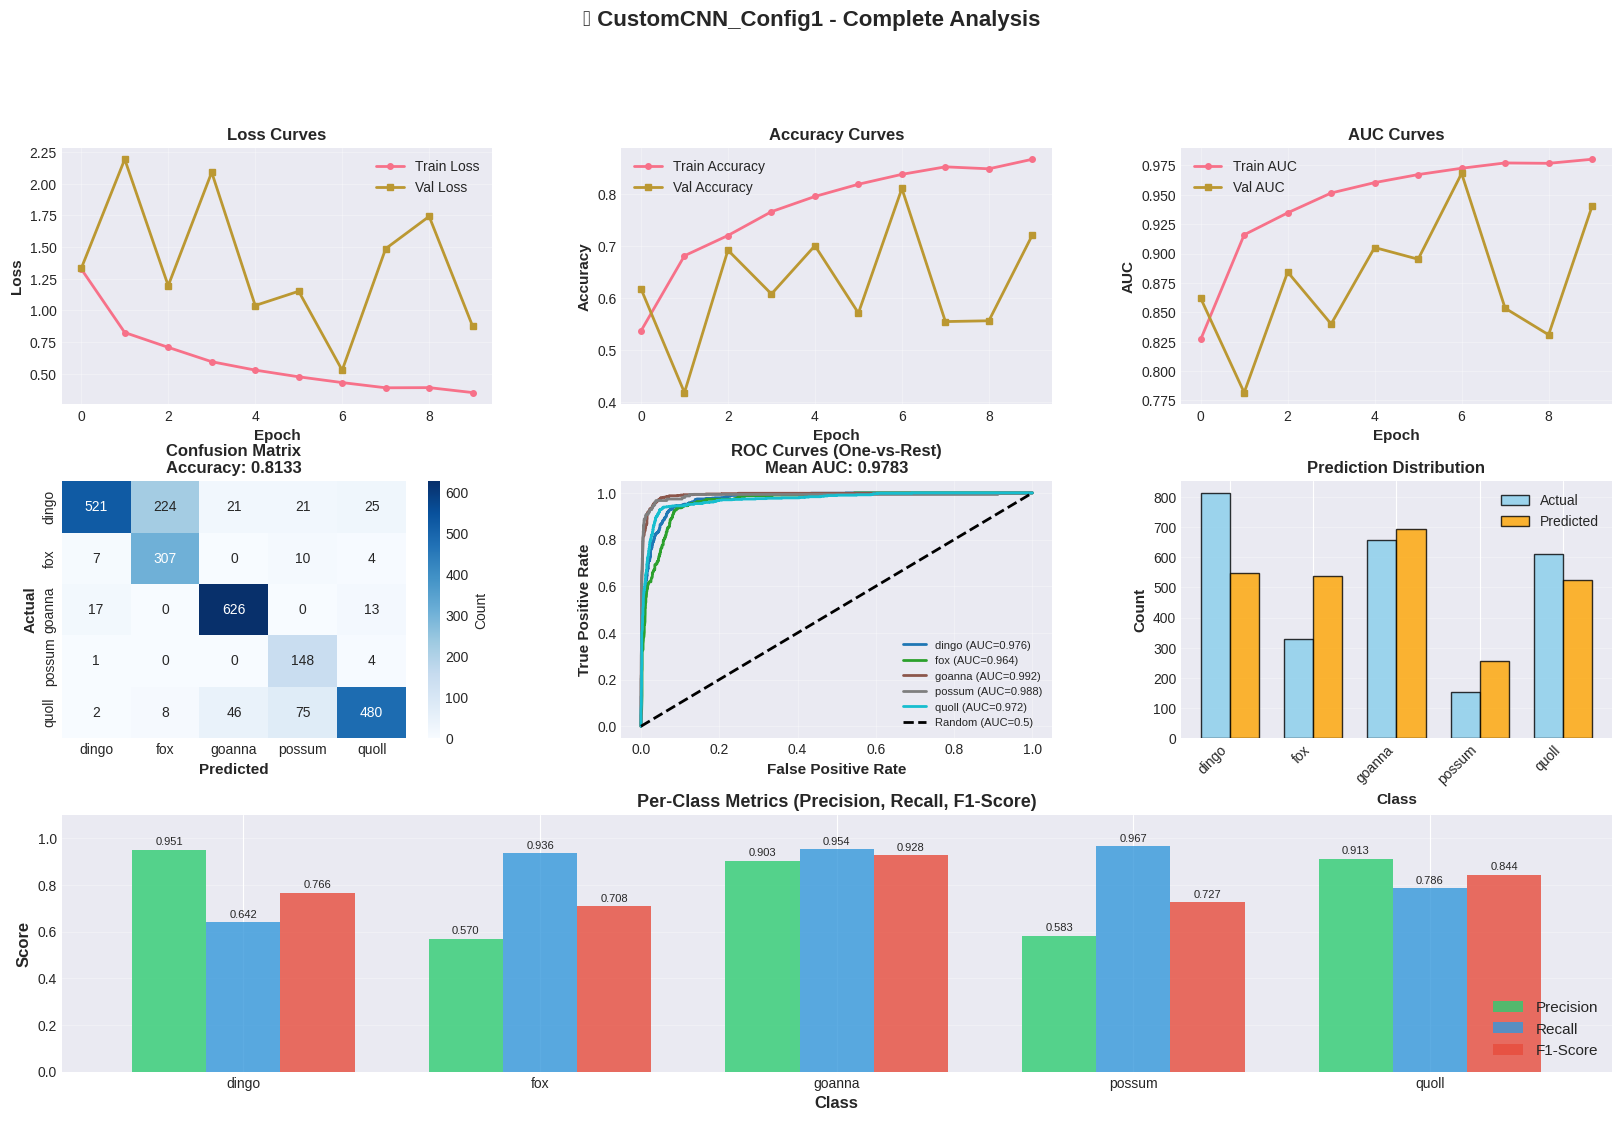

✓ Visualization complete for CustomCNN_Config1

✅ CustomCNN_Config1 Complete!
   Test Accuracy: 0.8133
   Mean AUC: 0.9783
✓ GPU memory cleaned


In [ ]:
# Train Custom CNN - Config 1
model_name = 'CustomCNN_Config1'
print(f"{'='*80}")
print(f"🏋️  Training {model_name}")
print(f"{'='*80}")

start_time = time.time()

# Get model and config
config = dl_configs[model_name]
model = config['model']

# Compile with optimizer designed for mixed precision
optimizer = config['optimizer']
if hasattr(optimizer, 'learning_rate'):
    # Wrap optimizer for mixed precision
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
print(f"Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
print(f"Batch size: {BATCH_SIZE}, Epochs: {config['epochs']}")
history = model.fit(
    train_dataset,
    epochs=config['epochs'],
    validation_data=val_dataset,
    callbacks=get_callbacks(model_name),
    class_weight=class_weights,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n⏱️  Training completed in {training_time/60:.2f} minutes")

# Store
dl_models[model_name] = model
dl_histories[model_name] = history.history

# Evaluate and visualize
results = evaluate_model(model, model_name, test_dataset, test_df)
dl_results[model_name] = results

print(f"\n📋 Classification Report:")
print("-"*80)
print(classification_report(results['y_true'], results['y_pred'], target_names=CLASSES, digits=4))

print(f"\n📈 Generating visualizations...")
plot_model_results(model_name, history.history, results)

print(f"\n✅ {model_name} Complete!")
print(f"   Test Accuracy: {results['test_acc']:.4f}")
print(f"   Mean AUC: {results['mean_auc']:.4f}")

# Clean up GPU memory
cleanup_memory()

#### Model 2: Custom CNN - Configuration 2

🏋️  Training CustomCNN_Config2
Optimizer: Adam, LR: 0.0005000000237487257
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5310 - auc: 0.8097 - loss: 1.3171
Epoch 1: val_loss improved from inf to 1.26150, saving model to /content/checkpoints/CustomCNN_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - accuracy: 0.5320 - auc: 0.8104 - loss: 1.3139 - val_accuracy: 0.5645 - val_auc: 0.8370 - val_loss: 1.2615 - learning_rate: 5.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7089 - auc: 0.9268 - loss: 0.7469
Epoch 2: val_loss improved from 1.26150 to 1.18826, saving model to /content/checkpoints/CustomCNN_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.7088 - auc: 0.9267 - loss: 0.7469 - val_accuracy: 0.7086 - val_auc: 0.9007 - val_loss: 1.1883 - learning_rate: 5.0000e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7605 - auc: 0.9466 - loss: 0.6135
Epoch 3: val_loss improved from 1.18826 to 1.02939, saving model to /content/checkpoints/CustomCNN_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.7606 - auc: 0.9466 - loss: 0.6132 - val_accuracy: 0.6770 - val_auc: 0.9147 - val_loss: 1.0294 - learning_rate: 5.0000e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8064 - auc: 0.9646 - loss: 0.4926
Epoch 4: val_loss improved from 1.02939 to 0.89662, saving model to /content/checkpoints/CustomCNN_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.8064 - auc: 0.9646 - loss: 0.4925 - val_accuracy: 0.7188 - val_auc: 0.9343 - val_loss: 0.8966 - learning_rate: 5.0000e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8346 - auc: 0.9748 - loss: 0.4147
Epoch 5: val_loss improved from 0.89662 to 0.72913, saving model to /content/checkpoints/CustomCNN_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.8347 - auc: 0.9748 - loss: 0.4146 - val_accuracy: 0.7625 - val_auc: 0.9471 - val_loss: 0.7291 - learning_rate: 5.0000e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8473 - auc: 0.9762 - loss: 0.3942
Epoch 6: val_loss did not improve from 0.72913
93/93 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.8474 - auc: 0.9762 - loss: 0.3940 - val_accuracy: 0.6770 - val_auc: 0.8842 - val_loss: 1.4656 - learning_rate: 5.0000e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8759 - auc: 0.9824 - loss: 0.3369
Epoch 7: val_loss did not improve from 0.72913
93/93 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.8758 - auc: 0.9824 - loss: 0.3369 - val_accuracy: 0.7441 - val_auc: 0.9431 - val_loss: 0.8210 - learning_rate: 5.0000e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8859 - auc: 0.9853 - loss: 0.3063
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: v

93/93 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.9105 - auc: 0.9907 - loss: 0.2294 - val_accuracy: 0.7805 - val_auc: 0.9512 - val_loss: 0.6538 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 10.

⏱️  Training completed in 59.04 minutes

📊 Evaluating CustomCNN_Config2...
✓ CustomCNN_Config2 Evaluation Complete:
  - Test Accuracy: 0.7801
  - Mean AUC: 0.9579

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9231    0.7389    0.8208       812
         fox     0.7126    0.7256    0.7190       328
      goanna     0.8102    0.9893    0.8909       656
      possum     0.3564    0.6732    0.4661       153
       quoll     0.8374    0.6661    0.7420       611

    accuracy                         0.7801      2560
   macro avg     0.7279    0.7586    0.7278      2560
weighted avg     0.8129    0.7801    0.7857      2560


📈 G

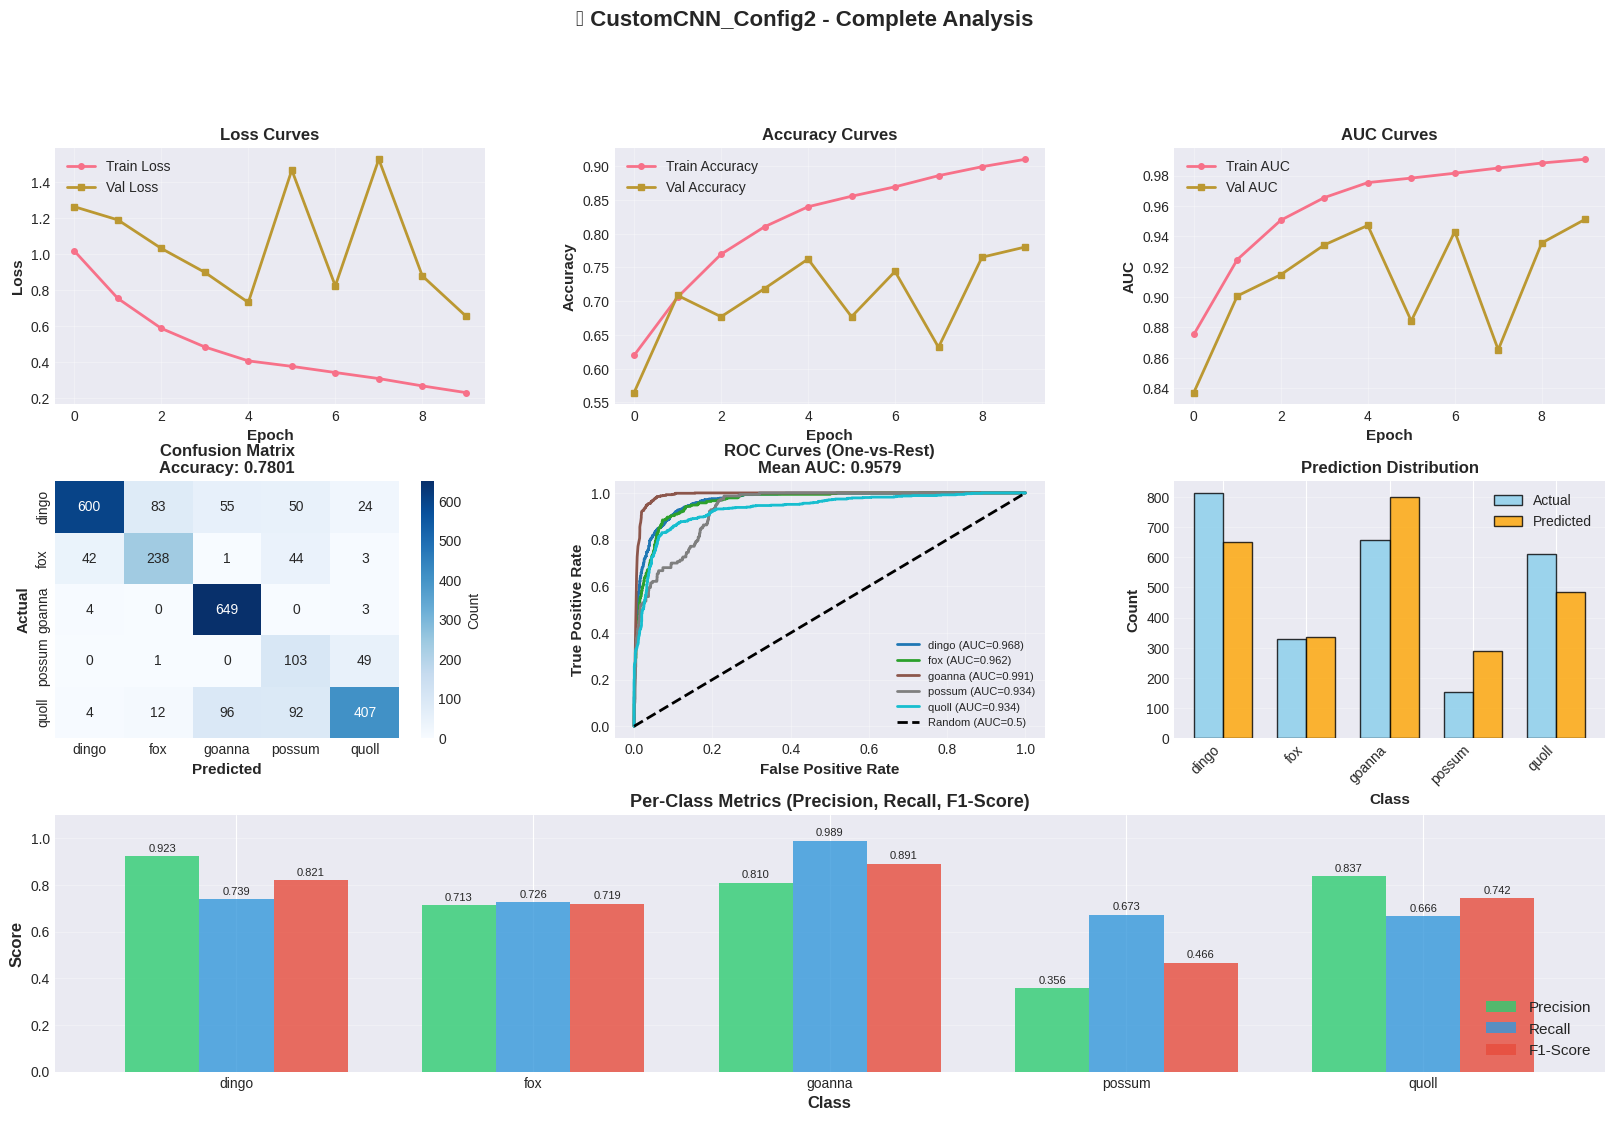

✓ Visualization complete for CustomCNN_Config2

✅ CustomCNN_Config2 Complete!
   Test Accuracy: 0.7801
   Mean AUC: 0.9579
✓ GPU memory cleaned


In [ ]:
# Train Custom CNN - Config 2
model_name = 'CustomCNN_Config2'
print(f"{'='*80}")
print(f"🏋️  Training {model_name}")
print(f"{'='*80}")

start_time = time.time()
config = dl_configs[model_name]
model = config['model']

# Compile
model.compile(
    optimizer=config['optimizer'],
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
print(f"Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
history = model.fit(
    train_dataset,
    epochs=config['epochs'],
    validation_data=val_dataset,
    callbacks=get_callbacks(model_name),
    class_weight=class_weights,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n⏱️  Training completed in {training_time/60:.2f} minutes")

# Store
dl_models[model_name] = model
dl_histories[model_name] = history.history

# Evaluate and visualize
results = evaluate_model(model, model_name, test_dataset, test_df)
dl_results[model_name] = results

print(f"\n📋 Classification Report:")
print("-"*80)
print(classification_report(results['y_true'], results['y_pred'], target_names=CLASSES, digits=4))

print(f"\n📈 Generating visualizations...")
plot_model_results(model_name, history.history, results)

print(f"\n✅ {model_name} Complete!")
print(f"   Test Accuracy: {results['test_acc']:.4f}")
print(f"   Mean AUC: {results['mean_auc']:.4f}")

# Clean up GPU memory
cleanup_memory()

#### Model 3: EfficientNetB0 - Configuration 1

🏋️  Training EfficientNetB0_Config1
Optimizer: AdamW, LR: 9.999999747378752e-05
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4620 - auc: 0.7452 - loss: 1.5277
Epoch 1: val_loss improved from inf to 0.59823, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.4639 - auc: 0.7467 - loss: 1.5223 - val_accuracy: 0.8723 - val_auc: 0.9782 - val_loss: 0.5982 - learning_rate: 1.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8184 - auc: 0.9646 - loss: 0.5102
Epoch 2: val_loss improved from 0.59823 to 0.34976, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.8185 - auc: 0.9646 - loss: 0.5098 - val_accuracy: 0.9090 - val_auc: 0.9896 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8647 - auc: 0.9789 - loss: 0.3852
Epoch 3: val_loss improved from 0.34976 to 0.25191, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.8647 - auc: 0.9790 - loss: 0.3850 - val_accuracy: 0.9262 - val_auc: 0.9931 - val_loss: 0.2519 - learning_rate: 1.0000e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8927 - auc: 0.9862 - loss: 0.3078
Epoch 4: val_loss improved from 0.25191 to 0.22462, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8927 - auc: 0.9862 - loss: 0.3078 - val_accuracy: 0.9281 - val_auc: 0.9934 - val_loss: 0.2246 - learning_rate: 1.0000e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9076 - auc: 0.9900 - loss: 0.2667
Epoch 5: val_loss improved from 0.22462 to 0.20309, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9076 - auc: 0.9900 - loss: 0.2667 - val_accuracy: 0.9363 - val_auc: 0.9943 - val_loss: 0.2031 - learning_rate: 1.0000e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9184 - auc: 0.9915 - loss: 0.2398
Epoch 6: val_loss improved from 0.20309 to 0.19199, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - accuracy: 0.9184 - auc: 0.9915 - loss: 0.2398 - val_accuracy: 0.9379 - val_auc: 0.9949 - val_loss: 0.1920 - learning_rate: 1.0000e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9269 - auc: 0.9932 - loss: 0.2253
Epoch 7: val_loss improved from 0.19199 to 0.17502, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9269 - auc: 0.9932 - loss: 0.2253 - val_accuracy: 0.9453 - val_auc: 0.9958 - val_loss: 0.1750 - learning_rate: 1.0000e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9333 - auc: 0.9943 - loss: 0.2049
Epoch 8: val_loss improved from 0.17502 to 0.16327, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9333 - auc: 0.9943 - loss: 0.2049 - val_accuracy: 0.9512 - val_auc: 0.9958 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9388 - auc: 0.9952 - loss: 0.1816
Epoch 9: val_loss improved from 0.16327 to 0.16162, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.9388 - auc: 0.9952 - loss: 0.1817 - val_accuracy: 0.9523 - val_auc: 0.9966 - val_loss: 0.1616 - learning_rate: 1.0000e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9400 - auc: 0.9954 - loss: 0.1805
Epoch 10: val_loss improved from 0.16162 to 0.15052, saving model to /content/checkpoints/EfficientNetB0_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9400 - auc: 0.9954 - loss: 0.1804 - val_accuracy: 0.9574 - val_auc: 0.9971 - val_loss: 0.1505 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

⏱️  Training completed in 51.69 minutes

📊 Evaluating EfficientNetB0_Config1...
✓ EfficientNetB0_Config1 Evaluation Complete:
  - Test Accuracy: 0.9539
  - Mean AUC: 0.9974

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9578    0.9507    0.9543       812
         fox     0.8913    0.8750    0.8831       328
      goanna     0.9804    0.9924    0.9864       656
      possum     0.9290    0.9412    0.9351       153
       quoll     0.9592    0.9624    0.9608       611

    accuracy                         0.9539      2560
   macro avg     0.9436    0.9443    0.9439      2560
weighted avg     0.9537    0.9539    0.9538      

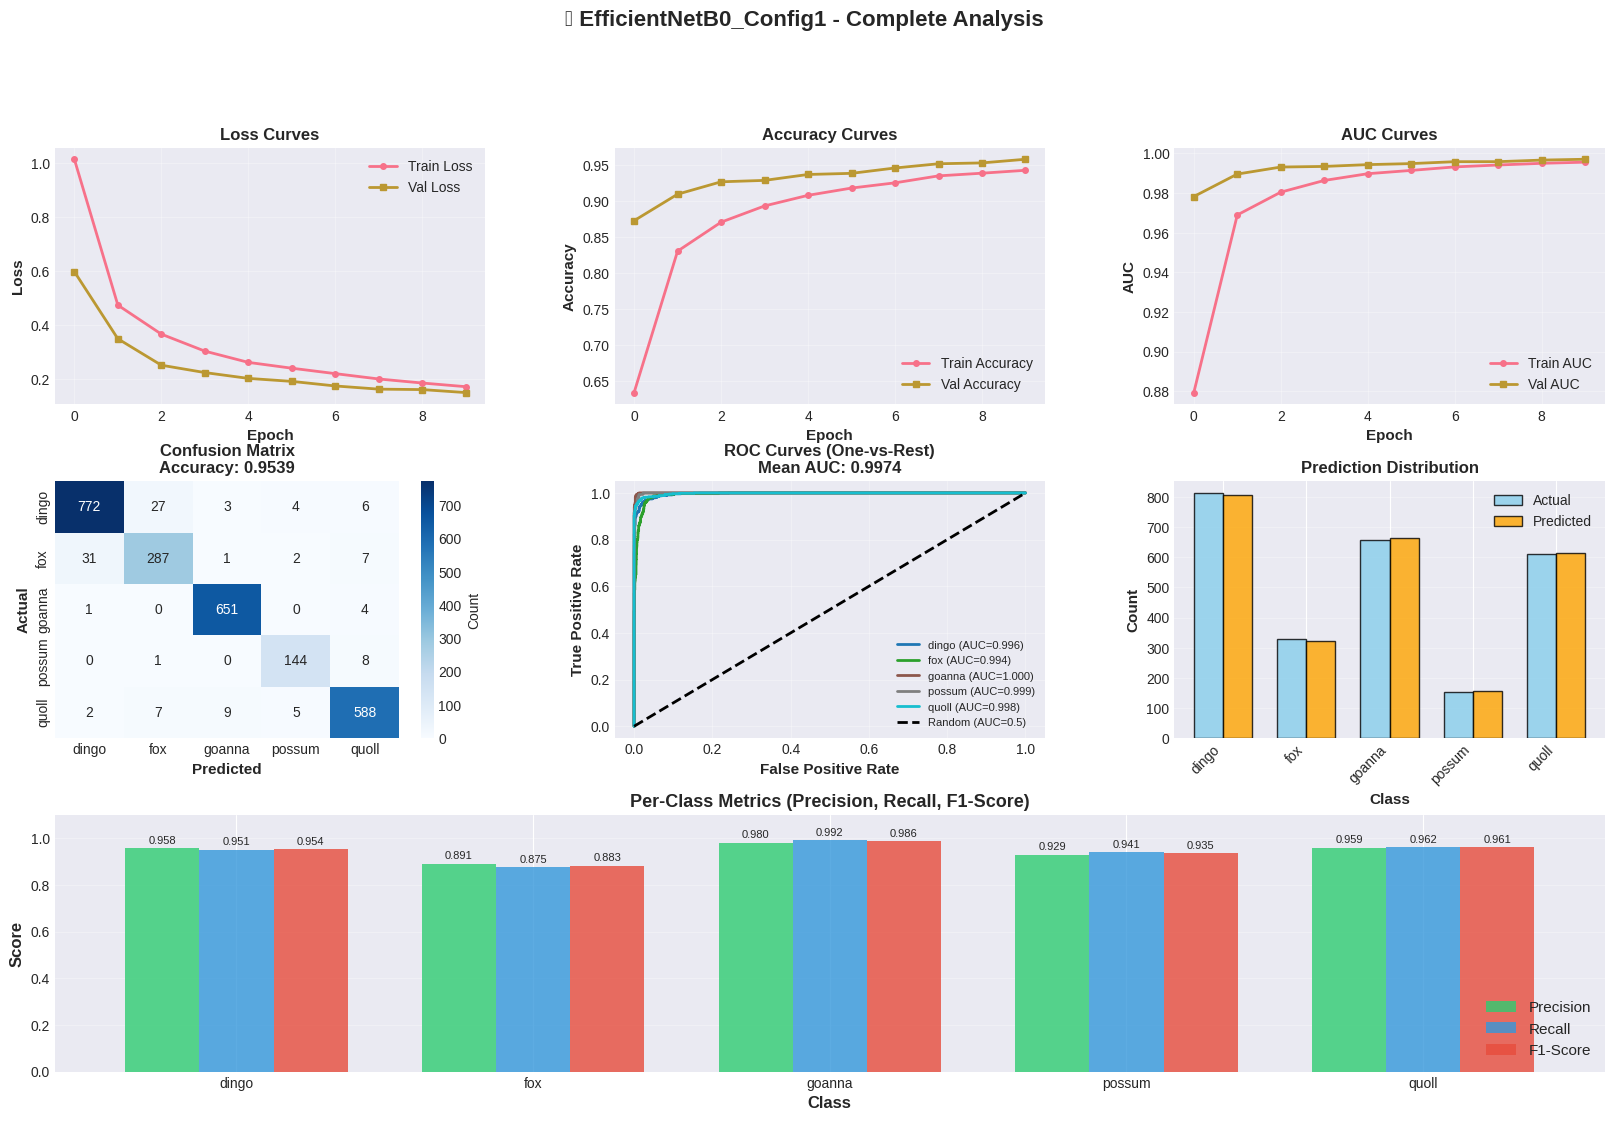

✓ Visualization complete for EfficientNetB0_Config1

✅ EfficientNetB0_Config1 Complete!
   Test Accuracy: 0.9539
   Mean AUC: 0.9974


In [ ]:
# Train EfficientNetB0 - Config 1
model_name = 'EfficientNetB0_Config1'
print(f"{'='*80}")
print(f"🏋️  Training {model_name}")
print(f"{'='*80}")

start_time = time.time()

# Get model and config
config = dl_configs[model_name]
model = config['model']

# Compile
model.compile(
    optimizer=config['optimizer'],
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
print(f"Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
history = model.fit(
    train_dataset,
    epochs=config['epochs'],
    validation_data=val_dataset,
    callbacks=get_callbacks(model_name),
    class_weight=class_weights,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n⏱️  Training completed in {training_time/60:.2f} minutes")

# Store
dl_models[model_name] = model
dl_histories[model_name] = history.history

# Evaluate and visualize
results = evaluate_model(model, model_name, test_dataset, test_df)
dl_results[model_name] = results

print(f"\n📋 Classification Report:")
print("-"*80)
print(classification_report(results['y_true'], results['y_pred'], target_names=CLASSES, digits=4))

print(f"\n📈 Generating visualizations...")
plot_model_results(model_name, history.history, results)

print(f"\n✅ {model_name} Complete!")
print(f"   Test Accuracy: {results['test_acc']:.4f}")
print(f"   Mean AUC: {results['mean_auc']:.4f}")

#### Model 4: EfficientNetB0 - Configuration 2

🏋️  Training EfficientNetB0_Config2
Optimizer: Adam, LR: 4.999999873689376e-05
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3565 - auc: 0.6578 - loss: 1.9186
Epoch 1: val_loss improved from inf to 0.75555, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.3580 - auc: 0.6592 - loss: 1.9132 - val_accuracy: 0.7766 - val_auc: 0.9501 - val_loss: 0.7555 - learning_rate: 5.0000e-05
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7102 - auc: 0.9194 - loss: 0.8037
Epoch 2: val_loss improved from 0.75555 to 0.49595, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.7105 - auc: 0.9195 - loss: 0.8029 - val_accuracy: 0.8359 - val_auc: 0.9727 - val_loss: 0.4960 - learning_rate: 5.0000e-05
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7906 - auc: 0.9538 - loss: 0.5888
Epoch 3: val_loss improved from 0.49595 to 0.36713, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.7907 - auc: 0.9538 - loss: 0.5885 - val_accuracy: 0.8758 - val_auc: 0.9841 - val_loss: 0.3671 - learning_rate: 5.0000e-05
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8299 - auc: 0.9681 - loss: 0.4855
Epoch 4: val_loss improved from 0.36713 to 0.31505, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8300 - auc: 0.9681 - loss: 0.4853 - val_accuracy: 0.8961 - val_auc: 0.9876 - val_loss: 0.3150 - learning_rate: 5.0000e-05
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8468 - auc: 0.9758 - loss: 0.4201
Epoch 5: val_loss improved from 0.31505 to 0.28123, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.8469 - auc: 0.9758 - loss: 0.4199 - val_accuracy: 0.9070 - val_auc: 0.9899 - val_loss: 0.2812 - learning_rate: 5.0000e-05
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8746 - auc: 0.9818 - loss: 0.3596
Epoch 6: val_loss improved from 0.28123 to 0.24733, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.8747 - auc: 0.9819 - loss: 0.3595 - val_accuracy: 0.9191 - val_auc: 0.9921 - val_loss: 0.2473 - learning_rate: 5.0000e-05
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8810 - auc: 0.9843 - loss: 0.3338
Epoch 7: val_loss improved from 0.24733 to 0.22773, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.8811 - auc: 0.9843 - loss: 0.3338 - val_accuracy: 0.9277 - val_auc: 0.9930 - val_loss: 0.2277 - learning_rate: 5.0000e-05
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8925 - auc: 0.9859 - loss: 0.3139
Epoch 8: val_loss improved from 0.22773 to 0.21619, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.8926 - auc: 0.9860 - loss: 0.3137 - val_accuracy: 0.9289 - val_auc: 0.9936 - val_loss: 0.2162 - learning_rate: 5.0000e-05
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9001 - auc: 0.9873 - loss: 0.2978
Epoch 9: val_loss improved from 0.21619 to 0.19838, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9001 - auc: 0.9873 - loss: 0.2977 - val_accuracy: 0.9352 - val_auc: 0.9947 - val_loss: 0.1984 - learning_rate: 5.0000e-05
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9125 - auc: 0.9895 - loss: 0.2649
Epoch 10: val_loss improved from 0.19838 to 0.19011, saving model to /content/checkpoints/EfficientNetB0_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.9125 - auc: 0.9895 - loss: 0.2649 - val_accuracy: 0.9367 - val_auc: 0.9953 - val_loss: 0.1901 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 10.

⏱️  Training completed in 49.96 minutes

📊 Evaluating EfficientNetB0_Config2...
✓ EfficientNetB0_Config2 Evaluation Complete:
  - Test Accuracy: 0.9406
  - Mean AUC: 0.9963

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9705    0.9310    0.9503       812
         fox     0.8661    0.8872    0.8765       328
      goanna     0.9656    0.9848    0.9751       656
      possum     0.7795    0.9935    0.8736       153
       quoll     0.9690    0.9214    0.9446       611

    accuracy                         0.9406      2560
   macro avg     0.9101    0.9436    0.9240      2560
weighted avg     0.9441    0.9406    0.9413      

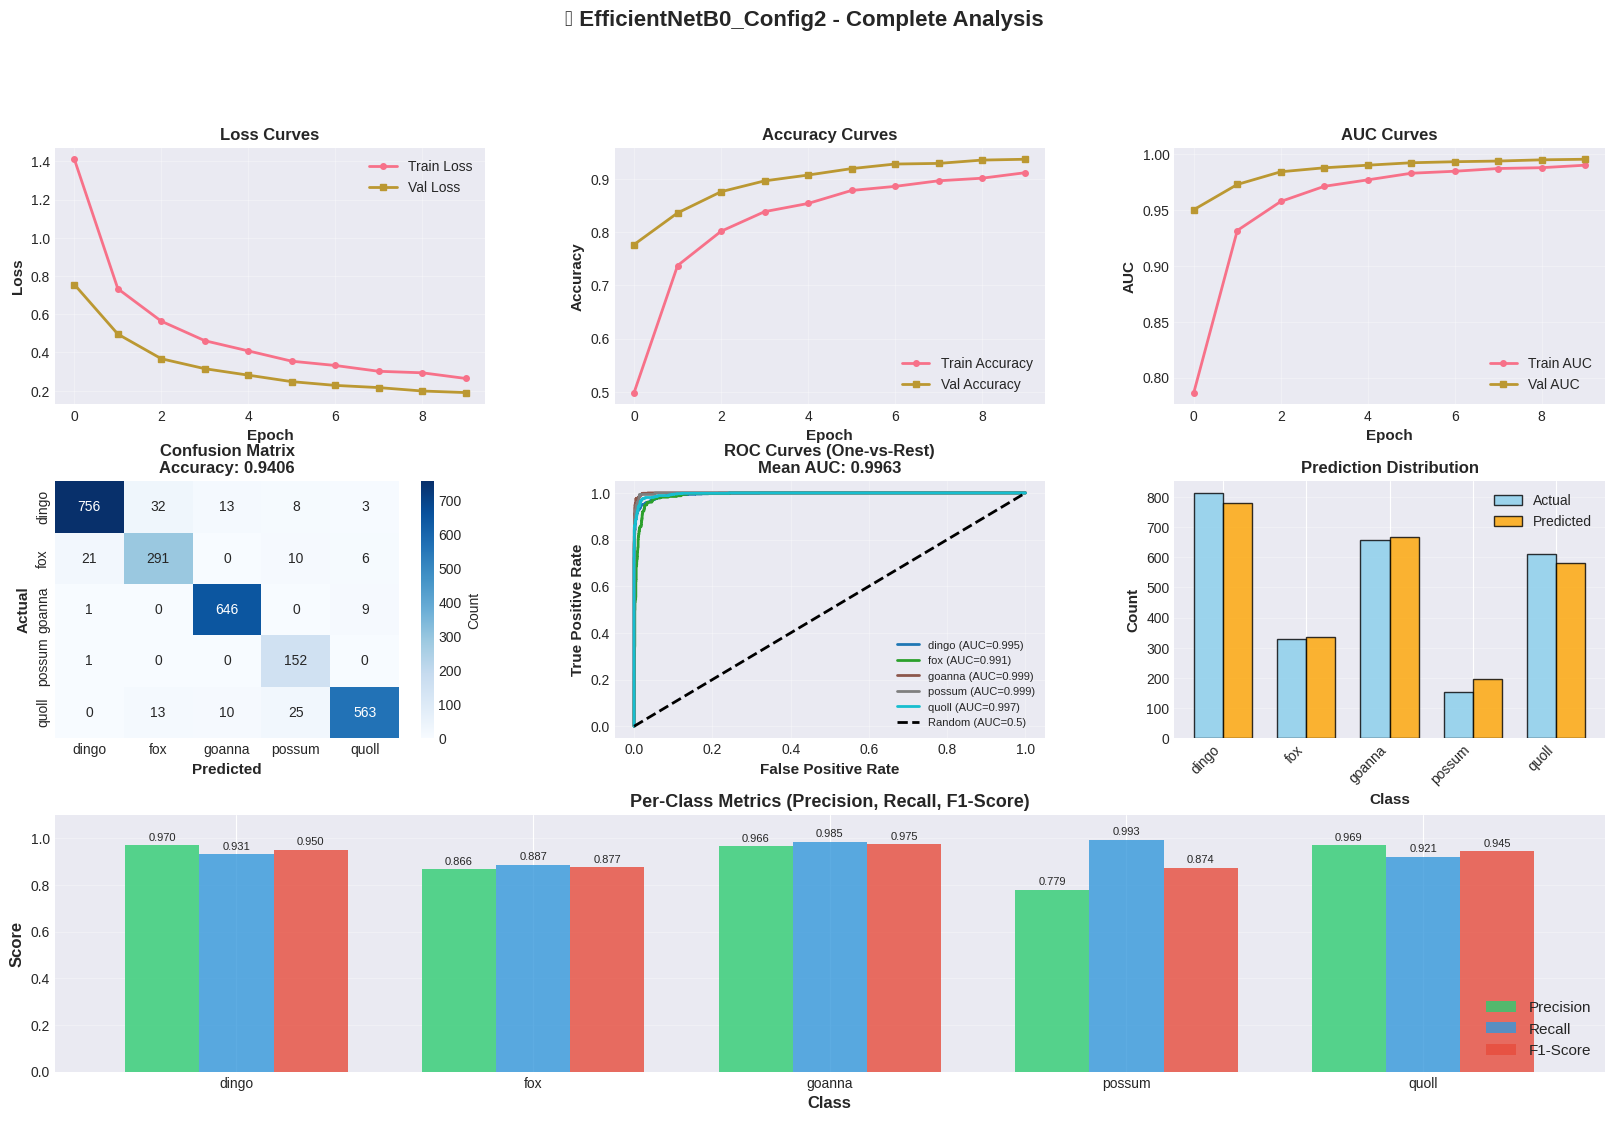

✓ Visualization complete for EfficientNetB0_Config2

✅ EfficientNetB0_Config2 Complete!
   Test Accuracy: 0.9406
   Mean AUC: 0.9963


In [ ]:
# Train EfficientNetB0 - Config 2
model_name = 'EfficientNetB0_Config2'
print(f"{'='*80}")
print(f"🏋️  Training {model_name}")
print(f"{'='*80}")

start_time = time.time()

# Get model and config
config = dl_configs[model_name]
model = config['model']

# Compile
model.compile(
    optimizer=config['optimizer'],
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
print(f"Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
history = model.fit(
    train_dataset,
    epochs=config['epochs'],
    validation_data=val_dataset,
    callbacks=get_callbacks(model_name),
    class_weight=class_weights,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n⏱️  Training completed in {training_time/60:.2f} minutes")

# Store
dl_models[model_name] = model
dl_histories[model_name] = history.history

# Evaluate and visualize
results = evaluate_model(model, model_name, test_dataset, test_df)
dl_results[model_name] = results

print(f"\n📋 Classification Report:")
print("-"*80)
print(classification_report(results['y_true'], results['y_pred'], target_names=CLASSES, digits=4))

print(f"\n📈 Generating visualizations...")
plot_model_results(model_name, history.history, results)

print(f"\n✅ {model_name} Complete!")
print(f"   Test Accuracy: {results['test_acc']:.4f}")
print(f"   Mean AUC: {results['mean_auc']:.4f}")

#### Model 5: ResNet50 - Configuration 1

🏋️  Training ResNet50_Config1
Optimizer: Adam, LR: 9.999999747378752e-05
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6060 - auc: 0.8480 - loss: 1.1729
Epoch 1: val_loss improved from inf to 0.38821, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.6075 - auc: 0.8489 - loss: 1.1681 - val_accuracy: 0.8789 - val_auc: 0.9821 - val_loss: 0.3882 - learning_rate: 1.0000e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8833 - auc: 0.9840 - loss: 0.3291
Epoch 2: val_loss improved from 0.38821 to 0.31179, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8833 - auc: 0.9841 - loss: 0.3289 - val_accuracy: 0.8980 - val_auc: 0.9886 - val_loss: 0.3118 - learning_rate: 1.0000e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9100 - auc: 0.9917 - loss: 0.2457
Epoch 3: val_loss improved from 0.31179 to 0.22733, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9101 - auc: 0.9917 - loss: 0.2455 - val_accuracy: 0.9340 - val_auc: 0.9932 - val_loss: 0.2273 - learning_rate: 1.0000e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9368 - auc: 0.9945 - loss: 0.1958
Epoch 4: val_loss improved from 0.22733 to 0.19675, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.9368 - auc: 0.9945 - loss: 0.1958 - val_accuracy: 0.9375 - val_auc: 0.9949 - val_loss: 0.1968 - learning_rate: 1.0000e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9479 - auc: 0.9963 - loss: 0.1591
Epoch 5: val_loss improved from 0.19675 to 0.18629, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9479 - auc: 0.9963 - loss: 0.1592 - val_accuracy: 0.9375 - val_auc: 0.9954 - val_loss: 0.1863 - learning_rate: 1.0000e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9574 - auc: 0.9971 - loss: 0.1342
Epoch 6: val_loss improved from 0.18629 to 0.16890, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9574 - auc: 0.9971 - loss: 0.1342 - val_accuracy: 0.9527 - val_auc: 0.9956 - val_loss: 0.1689 - learning_rate: 1.0000e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9627 - auc: 0.9983 - loss: 0.1184
Epoch 7: val_loss improved from 0.16890 to 0.15297, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9626 - auc: 0.9983 - loss: 0.1185 - val_accuracy: 0.9531 - val_auc: 0.9968 - val_loss: 0.1530 - learning_rate: 1.0000e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9671 - auc: 0.9984 - loss: 0.1094
Epoch 8: val_loss did not improve from 0.15297
93/93 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9671 - auc: 0.9984 - loss: 0.1095 - val_accuracy: 0.9465 - val_auc: 0.9947 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9683 - auc: 0.9980 - loss: 0.1180
Epoch 9: val_loss improved from 0.15297 to 0.13188, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9683 - auc: 0.9980 - loss: 0.1179 - val_accuracy: 0.9664 - val_auc: 0.9972 - val_loss: 0.1319 - learning_rate: 1.0000e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9718 - auc: 0.9987 - loss: 0.0964
Epoch 10: val_loss improved from 0.13188 to 0.12875, saving model to /content/checkpoints/ResNet50_Config1.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.9718 - auc: 0.9987 - loss: 0.0963 - val_accuracy: 0.9656 - val_auc: 0.9971 - val_loss: 0.1288 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

⏱️  Training completed in 54.20 minutes

📊 Evaluating ResNet50_Config1...
✓ ResNet50_Config1 Evaluation Complete:
  - Test Accuracy: 0.9543
  - Mean AUC: 0.9982

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9406    0.9754    0.9577       812
         fox     0.9493    0.8567    0.9006       328
      goanna     0.9424    0.9985    0.9697       656
      possum     0.9865    0.9542    0.9701       153
       quoll     0.9827    0.9313    0.9563       611

    accuracy                         0.9543      2560
   macro avg     0.9603    0.9432    0.9509      2560
weighted avg     0.9550    0.9543    0.9539      2560


📈 Gen

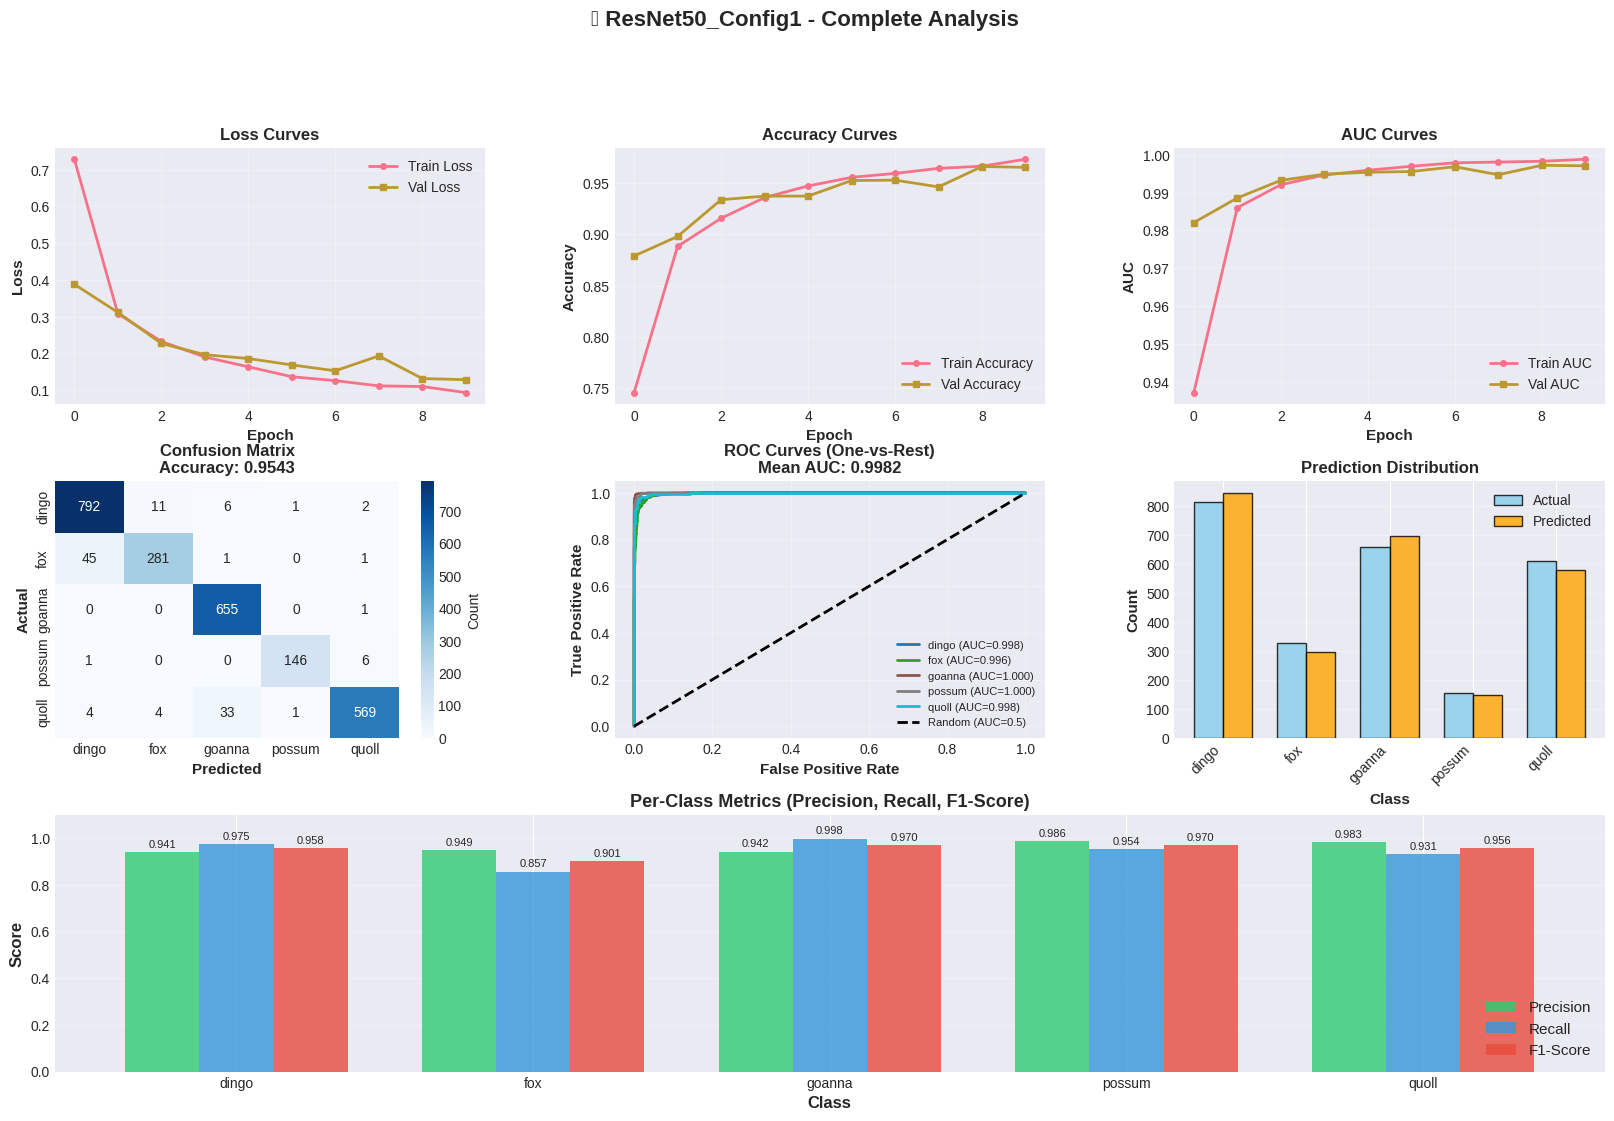

✓ Visualization complete for ResNet50_Config1

✅ ResNet50_Config1 Complete!
   Test Accuracy: 0.9543
   Mean AUC: 0.9982


In [ ]:
# Train ResNet50 - Config 1
model_name = 'ResNet50_Config1'
print(f"{'='*80}")
print(f"🏋️  Training {model_name}")
print(f"{'='*80}")

start_time = time.time()

# Get model and config
config = dl_configs[model_name]
model = config['model']

# Compile
model.compile(
    optimizer=config['optimizer'],
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
print(f"Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
history = model.fit(
    train_dataset,
    epochs=config['epochs'],
    validation_data=val_dataset,
    callbacks=get_callbacks(model_name),
    class_weight=class_weights,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n⏱️  Training completed in {training_time/60:.2f} minutes")

# Store
dl_models[model_name] = model
dl_histories[model_name] = history.history

# Evaluate and visualize
results = evaluate_model(model, model_name, test_dataset, test_df)
dl_results[model_name] = results

print(f"\n📋 Classification Report:")
print("-"*80)
print(classification_report(results['y_true'], results['y_pred'], target_names=CLASSES, digits=4))

print(f"\n📈 Generating visualizations...")
plot_model_results(model_name, history.history, results)

print(f"\n✅ {model_name} Complete!")
print(f"   Test Accuracy: {results['test_acc']:.4f}")
print(f"   Mean AUC: {results['mean_auc']:.4f}")

#### Model 6: ResNet50 - Configuration 2

🏋️  Training ResNet50_Config2
Optimizer: Adam, LR: 4.999999873689376e-05
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5310 - auc: 0.7984 - loss: 1.4257
Epoch 1: val_loss improved from inf to 0.51727, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.5326 - auc: 0.7996 - loss: 1.4202 - val_accuracy: 0.8504 - val_auc: 0.9682 - val_loss: 0.5173 - learning_rate: 5.0000e-05
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8557 - auc: 0.9782 - loss: 0.3929
Epoch 2: val_loss improved from 0.51727 to 0.33429, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.8558 - auc: 0.9783 - loss: 0.3926 - val_accuracy: 0.9066 - val_auc: 0.9848 - val_loss: 0.3343 - learning_rate: 5.0000e-05
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9041 - auc: 0.9888 - loss: 0.2758
Epoch 3: val_loss improved from 0.33429 to 0.25218, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.9041 - auc: 0.9888 - loss: 0.2757 - val_accuracy: 0.9293 - val_auc: 0.9916 - val_loss: 0.2522 - learning_rate: 5.0000e-05
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9238 - auc: 0.9932 - loss: 0.2173
Epoch 4: val_loss improved from 0.25218 to 0.23441, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.9239 - auc: 0.9932 - loss: 0.2172 - val_accuracy: 0.9316 - val_auc: 0.9925 - val_loss: 0.2344 - learning_rate: 5.0000e-05
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9455 - auc: 0.9959 - loss: 0.1664
Epoch 5: val_loss improved from 0.23441 to 0.18068, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.9455 - auc: 0.9959 - loss: 0.1663 - val_accuracy: 0.9469 - val_auc: 0.9957 - val_loss: 0.1807 - learning_rate: 5.0000e-05
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9538 - auc: 0.9963 - loss: 0.1519
Epoch 6: val_loss improved from 0.18068 to 0.16296, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.9539 - auc: 0.9963 - loss: 0.1518 - val_accuracy: 0.9520 - val_auc: 0.9963 - val_loss: 0.1630 - learning_rate: 5.0000e-05
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9623 - auc: 0.9979 - loss: 0.1226
Epoch 7: val_loss improved from 0.16296 to 0.15653, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9623 - auc: 0.9979 - loss: 0.1226 - val_accuracy: 0.9570 - val_auc: 0.9956 - val_loss: 0.1565 - learning_rate: 5.0000e-05
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9678 - auc: 0.9978 - loss: 0.1135
Epoch 8: val_loss improved from 0.15653 to 0.14516, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9678 - auc: 0.9978 - loss: 0.1134 - val_accuracy: 0.9570 - val_auc: 0.9962 - val_loss: 0.1452 - learning_rate: 5.0000e-05
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9718 - auc: 0.9984 - loss: 0.1030
Epoch 9: val_loss improved from 0.14516 to 0.12711, saving model to /content/checkpoints/ResNet50_Config2.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.9718 - auc: 0.9984 - loss: 0.1030 - val_accuracy: 0.9641 - val_auc: 0.9977 - val_loss: 0.1271 - learning_rate: 5.0000e-05
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9757 - auc: 0.9989 - loss: 0.0852
Epoch 10: val_loss did not improve from 0.12711
93/93 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.9756 - auc: 0.9989 - loss: 0.0852 - val_accuracy: 0.9641 - val_auc: 0.9964 - val_loss: 0.1426 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.

⏱️  Training completed in 51.95 minutes

📊 Evaluating ResNet50_Config2...
✓ ResNet50_Config2 Evaluation Complete:
  - Test Accuracy: 0.9629
  - Mean AUC: 0.9983

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9773    0.9557    0.9664       812
         fox     0.9077    0.9299    0.9187       328
      goann

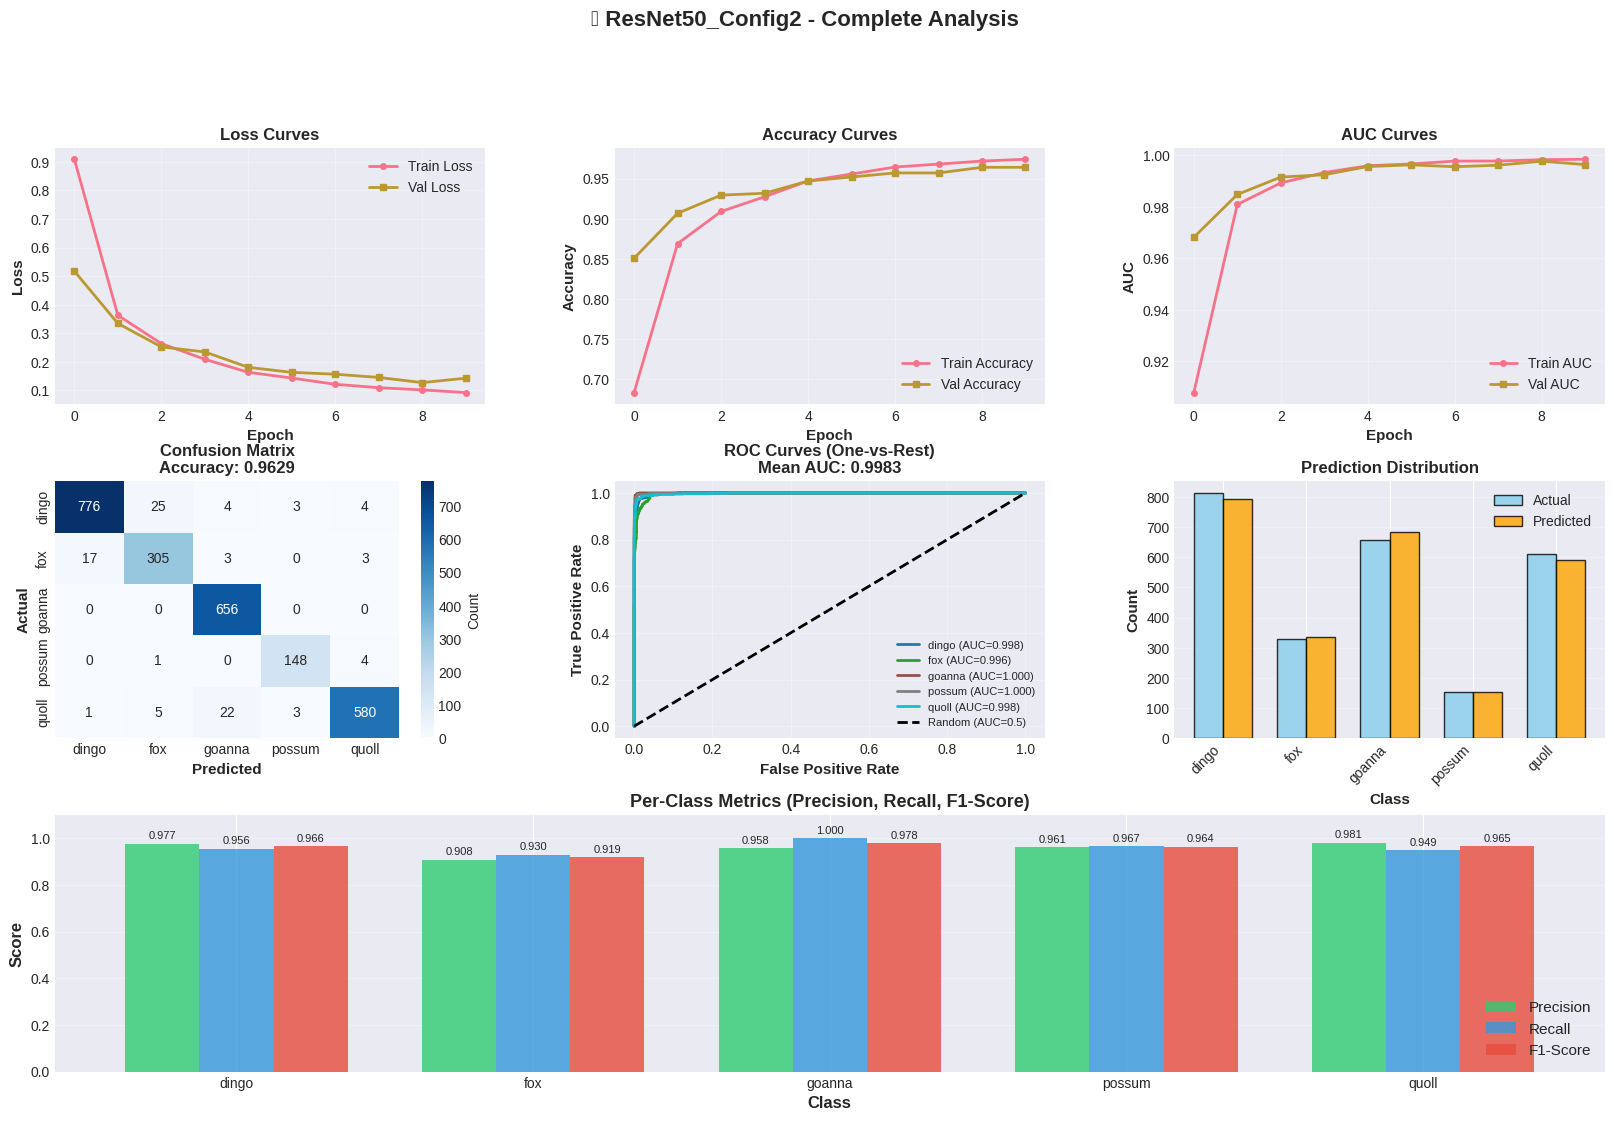

✓ Visualization complete for ResNet50_Config2

✅ ResNet50_Config2 Complete!
   Test Accuracy: 0.9629
   Mean AUC: 0.9983


In [ ]:
# Train ResNet50 - Config 2
model_name = 'ResNet50_Config2'
print(f"{'='*80}")
print(f"🏋️  Training {model_name}")
print(f"{'='*80}")

start_time = time.time()

# Get model and config
config = dl_configs[model_name]
model = config['model']

# Compile
model.compile(
    optimizer=config['optimizer'],
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Train
print(f"Optimizer: {config['optimizer'].__class__.__name__}, LR: {config['optimizer'].learning_rate.numpy()}")
history = model.fit(
    train_dataset,
    epochs=config['epochs'],
    validation_data=val_dataset,
    callbacks=get_callbacks(model_name),
    class_weight=class_weights,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n⏱️  Training completed in {training_time/60:.2f} minutes")

# Store
dl_models[model_name] = model
dl_histories[model_name] = history.history

# Evaluate and visualize
results = evaluate_model(model, model_name, test_dataset, test_df)
dl_results[model_name] = results

print(f"\n📋 Classification Report:")
print("-"*80)
print(classification_report(results['y_true'], results['y_pred'], target_names=CLASSES, digits=4))

print(f"\n📈 Generating visualizations...")
plot_model_results(model_name, history.history, results)

print(f"\n✅ {model_name} Complete!")
print(f"   Test Accuracy: {results['test_acc']:.4f}")
print(f"   Mean AUC: {results['mean_auc']:.4f}")

# FINAL COMPARISON: All Trained Models

In [ ]:
# ==========================
# 📊 FINAL COMPARISON: All Trained Models
# ==========================
print("\n" + "="*80)
print("📊 FINAL MODEL COMPARISON - DEEP LEARNING MODELS")
print("="*80)

# Check if any models have been trained
if len(dl_results) == 0:
    print("No models have been trained yet!")
    print("Please train at least one model before running this comparison.")
else:
    # Create comprehensive comparison table
    comparison_data = []

    for model_name, results in dl_results.items():
        comparison_data.append({
            'Model': model_name,
            'Test Accuracy': results['test_acc'],
            'Mean AUC': results['mean_auc'],
            'Total Params': dl_models[model_name].count_params()
        })

    # Create DataFrame and sort by accuracy
    comparison_df = pd.DataFrame(comparison_data).sort_values('Test Accuracy', ascending=False)
    comparison_df['Rank'] = range(1, len(comparison_df) + 1)
    comparison_df = comparison_df[['Rank', 'Model', 'Test Accuracy', 'Mean AUC', 'Total Params']]

    # Display table
    print(f"\n📈 Model Performance Ranking ({len(dl_results)} models trained):")
    print("-"*80)
    print(comparison_df.to_string(index=False))
    print("-"*80)

    # Find best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_accuracy = comparison_df.iloc[0]['Test Accuracy']
    best_auc = comparison_df.iloc[0]['Mean AUC']

    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Test Accuracy: {best_accuracy:.4f}")
    print(f"   Mean AUC: {best_auc:.4f}")
    print("="*80)

    # Per-class performance for best model
    print(f"\n📋 Best Model ({best_model_name}) - Per-Class Performance:")
    print("-"*80)
    best_results = dl_results[best_model_name]
    print(classification_report(best_results['y_true'], best_results['y_pred'],
                                target_names=CLASSES, digits=4))

    # Statistical summary
    print(f"\n📊 Statistical Summary:")
    print("-"*80)
    print(f"Models Trained: {len(dl_results)}")
    print(f"Mean Accuracy: {comparison_df['Test Accuracy'].mean():.4f}")
    print(f"Std Accuracy: {comparison_df['Test Accuracy'].std():.4f}")
    print(f"Mean AUC: {comparison_df['Mean AUC'].mean():.4f}")
    print(f"Std AUC: {comparison_df['Mean AUC'].std():.4f}")
    print("-"*80)

    # Model architecture comparison
    print(f"\n🏗️  Model Architecture Comparison:")
    print("-"*80)
    for idx, row in comparison_df.iterrows():
        model_name = row['Model']
        model_type = model_name.split('_')[0]
        print(f"{row['Rank']}. {model_name}")
        print(f"   Type: {model_type}")
        print(f"   Parameters: {row['Total Params']:,}")
        print(f"   Accuracy: {row['Test Accuracy']:.4f}")
        print(f"   AUC: {row['Mean AUC']:.4f}")
        print("-"*40)

    print("="*80)


📊 FINAL MODEL COMPARISON - DEEP LEARNING MODELS

📈 Model Performance Ranking (2 models trained):
--------------------------------------------------------------------------------
 Rank            Model  Test Accuracy  Mean AUC  Total Params
    1 ResNet50_Config2       0.962891  0.998326      23859333
    2 ResNet50_Config1       0.954297  0.998228      23859333
--------------------------------------------------------------------------------

🏆 BEST MODEL: ResNet50_Config2
   Test Accuracy: 0.9629
   Mean AUC: 0.9983

📋 Best Model (ResNet50_Config2) - Per-Class Performance:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9773    0.9557    0.9664       812
         fox     0.9077    0.9299    0.9187       328
      goanna     0.9577    1.0000    0.9784       656
      possum     0.9610    0.9673    0.9642       153
       quoll     0.9814    0.9493    0.9651       611

    accuracy